In [1]:
# !pip install -U matplotlib --quiet
# !pip install torch --quiet
# !pip install lightning --quiet

In [2]:
# !git clone https://github.com/QMCSoftware/QMCSoftware
# !cd QMCSoftware && git checkout qmctoolscl_integration
# !cd QMCSoftware && git pull
# !cd QMCSoftware && pip install -e .

# CHONKNORIS for a 1 dimensional non-linear elliptic PDE

Here we will solve the PDE

$$\begin{cases} C_1 v^3 + C_2 \Delta v = u, & x \in [0,1] \\ v = 0, &x \in \partial [0,1]^d \end{cases}$$

where $\Delta$ is the Laplacian, $u$ is random and $v$ is the unknown PDE solution.    

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # cholesky not implemented on MPS, fall back to CPU
import torch

In [2]:
# may need to Runtime > Restart session if loading for the first time on Google Colab
import torch
import qmcpy as qp
import pandas as pd
import numpy as np
import lightning
import gpytorch
import time
from collections import OrderedDict
import os
import glob
import warnings
from typing import List

In [3]:
ROOT = "."
assert os.path.isfile(ROOT+"/elliptic_pde_1d.ipynb")

In [4]:
assert torch.cuda.is_available() or torch.backends.mps.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "mps"
DEVICE

'cuda'

In [5]:
from matplotlib import pyplot,cm,colors,gridspec
#print(pyplot.style.available)
pyplot.style.use('seaborn-v0_8-whitegrid') 
LW = 3 # linewidth
LWTHIN = 0.01
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()]

## Reference Solution

We will randomly generate
$$v(x) = \exp\left(-\frac{1}{1-r(x)^2}\right)\left[\sum_{p=1}^P a_p \sin(p \pi x)\right] 1_{x \in (0,1)}$$
where $r(x)=2x-1$ and $(a_1,\dots,a_P) \sim \mathcal{U}[-\overline{B},\underline{B}]^P$. We will use auto-diff to find $u$.

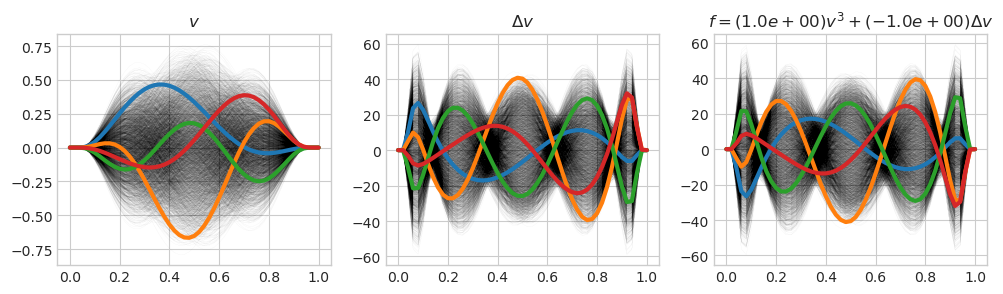

In [6]:
C1 = 1.
C2 = -1#./100
def v(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    P = len(a)
    assert a.shape==(P,)
    y = torch.zeros_like(x)
    r = 2*x-1
    b = torch.abs(r)<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = (a[:,None]*torch.sin(torch.arange(1,P+1)[:,None]*torch.pi*x[None,b])).sum(0)
    y[b] = t1*t2
    return y
def v_laplace(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    xg = x.clone().requires_grad_()
    yg = v(xg,a)
    grad_outputs = torch.ones_like(x)
    ypg = torch.autograd.grad(yg,xg,grad_outputs,create_graph=True)[0]
    yppg = torch.autograd.grad(ypg,xg,grad_outputs,create_graph=True)[0]
    return yppg.detach()
def u(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    return C1*v(x,a)**3+C2*v_laplace(x,a)
R = 2**12
P = 3
B_low = -1.
B_high = 1.
dnb2 = qp.DigitalNetB2(P,seed=7,graycode=True,t_lms=32)
unif_dnb2 = qp.Uniform(dnb2,lower_bound=B_low,upper_bound=B_high)
a = torch.from_numpy(unif_dnb2.gen_samples(R))
nxticks = 51
xticks = torch.linspace(0,1,nxticks,dtype=float)
vticks = torch.vstack([v(xticks,a=a[r]) for r in range(R)])
vlticks = torch.vstack([v_laplace(xticks,a=a[r]) for r in range(R)])
uticks = torch.vstack([u(xticks,a=a[r]) for r in range(R)])
if True:
    fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,3))
    coloridxs = torch.arange(4)
    ax[0].plot(xticks,vticks.T,color='k',linewidth=LWTHIN)
    ax[1].plot(xticks,vlticks.T,color='k',linewidth=LWTHIN)
    ax[2].plot(xticks,uticks.T,color='k',linewidth=LWTHIN)
    ax[0].plot(xticks,vticks.T[:,coloridxs],linewidth=LW)
    ax[1].plot(xticks,vlticks.T[:,coloridxs],linewidth=LW)
    ax[2].plot(xticks,uticks.T[:,coloridxs],linewidth=LW)
    ax[0].set_title(r"$v$")
    ax[1].set_title(r"$\Delta v$")
    ax[2].set_title(r"$f = (%.1e) v^3 + (%.1e) \Delta v$"%(C1,C2));

## GP for PDE Solves

In [7]:
llbetas = [ # derivative orders
    [ # interior
        torch.tensor([[0]],dtype=int), # v
        torch.tensor([[2]],dtype=int), # laplacian v
    ],
    [ # boundary
        torch.tensor([[0]],dtype=int) # v
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # v
        torch.ones(1,dtype=float) # laplacian v
    ],
    [ # boundary
        torch.ones(1,dtype=float) # v
    ]
]
xs = [xticks[:,None],torch.tensor([[0],[1]],dtype=float)]

In [8]:
noise = 1e-8
#dd_obj = qp.DigitalNetB2(dimension=1,seed=7) # collocation points
#kernel = qp.KernelShiftInvar(dimension=1,lengthscales=1e-1,alpha=4,scale=1.,torchify=True) # kernel
kernel = qp.KernelGaussian(dimension=1,lengthscales=2e-3,scale=1.,torchify=True) # kernel
ki = qp.PDEGramMatrix(kernel,xs,None,None,llbetas,llcs,noise) # kernel interpolant

r from 0 to 4096, l2 relative errors
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
r = 256: [1.0e+00 1.1e-02 2.3e-04 2.4e-04 2.4e-04 2.4e-04]
r = 512: [1.0e+00 2.1e-02 1.5e-04 1.3e-04 1.3e-04 1.3e-04]
r = 768: [1.0e+00 1.2e-02 2.6e-05 2.6e-05 2.6e-05 2.6e-05]
r = 1024: [1.0e+00 1.3e-02 4.4e-04 4.4e-04 4.4e-04 4.4e-04]
r = 1280: [1.0e+00 5.3e-03 4.7e-04 4.7e-04 4.7e-04 4.7e-04]
r = 1536: [1.0e+00 1.2e-02 9.7e-05 9.9e-05 9.9e-05 9.9e-05]
r = 1792: [1.0e+00 2.4e-02 1.7e-04 1.5e-04 1.5e-04 1.5e-04]
r = 2048: [1.0e+00 4.9e-03 3.1e-04 3.1e-04 3.1e-04 3.1e-04]
r = 2304: [1.0e+00 1.6e-02 8.1e-05 7.3e-05 7.3e-05 7.3e-05]
r = 2560: [1.0e+00 1.3e-02 1.7e-04 1.7e-04 1.7e-04 1.7e-04]
r = 2816: [1.0e+00 9.5e-03 5.1e-04 5.1e-04 5.1e-04 5.1e-04]
r = 3072: [1.0e+00 1.4e-02 5.6e-05 5.4e-05 5.4e-05 5.4e-05]
r = 3328: [1.0e+00 1.5e-02 1.4e-04 1.4e-04 1.4e-04 1.4e-04]
r = 3584: [1.0e+00 4.8e-03 4.5e-04 4.5e-04 4.5e-04 4.5e-04]
r = 3840: [1.0e+00 6.3e-0

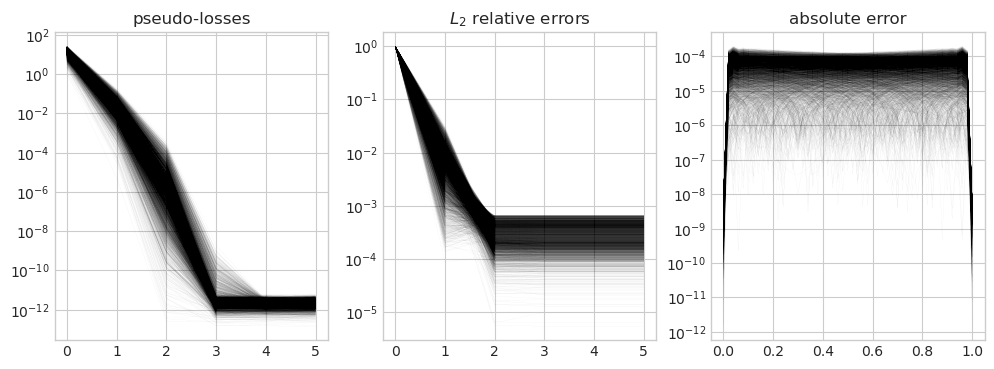

In [9]:
kvec = ki.get_new_left_full_gram_matrix(xticks[:,None])
def get_data(maxiter=10, tag="full", force_gen=False):
    fname = "%s/%s.%s"%(ROOT,"elliptic_pde_1d_data",tag)
    if (not os.path.exists(fname+".npz")) or force_gen:
        data = {
            "vopt": np.empty((R,maxiter+1,ki.length)),
            "losses_opt": np.empty((R,maxiter+1)),
            "vhats": np.empty((R,maxiter+1,nxticks)),
            "l2relerrors": np.empty((R,maxiter+1)),
            "L_chols": np.empty((R,maxiter,ki.ntot,ki.ntot)),
            "times": np.empty((R,maxiter+1))}
        print("r from 0 to %d, l2 relative errors\n"%(R)+"~"*100)
        verbosity = max(R//16,1)
        for r in range(R):
            if (r+1)%verbosity==0: print("r = %d: "%(r+1),end='',flush=True)
            def pde_lhs_r(ly_i, ly_b):
                v_i,v_laplace_i = ly_i
                v_b = ly_b[0]
                lhs_i = C1*v_i**3+C2*v_laplace_i
                lhs_b = v_b
                return lhs_i,lhs_b
            def pde_rhs_r(x_i, x_b):
                y_i = uticks[r]
                y_b = torch.zeros(len(x_b),dtype=float)
                return y_i,y_b
            y,data_r = ki.pde_opt_gauss_newton(
                pde_lhs = pde_lhs_r,
                pde_rhs = pde_rhs_r,
                maxiter = maxiter,
                store_L_chol_hist = True,
                verbose = False)
            data["vopt"][r] = data_r["zhist"].numpy()
            data["losses_opt"][r] = data_r["losses"].numpy()
            data["vhats"][r] = (kvec@ki._solve(data_r["zhist"].T)).T.numpy()
            data["l2relerrors"][r] = (torch.linalg.norm(data_r["zhist"][:,:nxticks]-vticks[r],dim=1)/torch.linalg.norm(vticks[r])).numpy()
            data["L_chols"][r] = data_r["L_chol_hist"].numpy()
            data["times"][r] = data_r["times"].numpy()
            if (r+1)%verbosity==0:
                with np.printoptions(formatter={"float":lambda x: "%.1e"%x}):
                    print(data["l2relerrors"][r])
        np.savez_compressed(fname,**data)
    data = np.load(fname+".npz")
    return (
        torch.from_numpy(data["vopt"]),
        torch.from_numpy(data["losses_opt"]),
        torch.from_numpy(data["l2relerrors"]),
        torch.from_numpy(data["L_chols"]),
        torch.from_numpy(data["times"]))
maxiter = 5
vopt,losses_opt,l2rerrs,L_chols,times = get_data(maxiter=maxiter,tag="bigeasy",force_gen=False)
with np.printoptions(formatter={"float":lambda x: "%.1e"%x}):
    print("iter avg l2rerrs:",l2rerrs.mean(0).numpy())
best_idxs = losses_opt.argmin(1)
vopt_best = vopt[np.arange(R),best_idxs,:]
if True:
    fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,4))
    ax[0].set_title("pseudo-losses")
    ax[0].plot(torch.arange(losses_opt.size(1)),losses_opt.T,color="k",linewidth=LWTHIN)
    ax[0].set_yscale("log",base=10)
    ax[1].set_title(r"$L_2$ relative errors")
    ax[1].plot(torch.arange(l2rerrs.size(1)),l2rerrs.T,color="k",linewidth=LWTHIN)
    ax[1].set_yscale("log",base=10)
    ax[2].set_title("absolute error")
    ax[2].plot(xticks,torch.abs(vopt_best[:,:nxticks]-vticks).T,color="k",linewidth=LWTHIN)
    ax[2].set_yscale("log",base=10);

## Data

### Train-test split

In [10]:
(
uticks_train,uticks_val,
vopt_train,vopt_val,
vticks_train,vticks_val,
L_chols_train,L_chols_val,
l2rerrs_train,l2rerrs_val,
times_train,times_val
) = qp.train_val_split(R,[uticks,vopt,vticks,L_chols,l2rerrs,times],val_frac=1/8,shuffle=False)
print("uticks_train.shape:",tuple(uticks_train.shape))
print("vopt_train.shape:",tuple(vopt_train.shape))
print("vticks_train.shape:",tuple(vticks_train.shape))
print("L_chols_train.shape:",tuple(L_chols_train.shape))
print()
print("uticks_val.shape:",tuple(uticks_val.shape))
print("vopt_val.shape:",tuple(vopt_val.shape))
print("vticks_val.shape:",tuple(vticks_val.shape))
print("L_chols_val.shape:",tuple(L_chols_val.shape))

uticks_train.shape: (3584, 51)
vopt_train.shape: (3584, 6, 104)
vticks_train.shape: (3584, 51)
L_chols_train.shape: (3584, 5, 53, 53)

uticks_val.shape: (512, 51)
vopt_val.shape: (512, 6, 104)
vticks_val.shape: (512, 51)
L_chols_val.shape: (512, 5, 53, 53)


## Operator Learning Lower Triangular Matrix

In [11]:
relaxations = torch.tensor([5e-2])
dataset_chonknoris_train = qp.DatasetLowerTriMatOpLearn(vopt_train[:,:,:nxticks],L_chols_train,relaxations=relaxations,device=DEVICE,steps=4,fp32=False)
dataset_chonknoris_val = qp.DatasetLowerTriMatOpLearn(vopt_val[:,:,:nxticks],L_chols_val,relaxations=relaxations,device=DEVICE,steps=4,fp32=False)
dataloader_chonknoris_train = torch.utils.data.DataLoader(dataset_chonknoris_train,batch_size=2**8,collate_fn=tuple,shuffle=True)
dataloader_chonknoris_val = torch.utils.data.DataLoader(dataset_chonknoris_val,batch_size=len(dataset_chonknoris_val),collate_fn=tuple,shuffle=False)
print("len(dataset_chonknoris_train):",len(dataset_chonknoris_train))
print("len(dataset_chonknoris_val):",len(dataset_chonknoris_val))
print("len(dataloader_chonknoris_train):",len(dataloader_chonknoris_train))
print("len(dataloader_chonknoris_val):",len(dataloader_chonknoris_val))

len(dataset_chonknoris_train): 10753
len(dataset_chonknoris_val): 1537
len(dataloader_chonknoris_train): 43
len(dataloader_chonknoris_val): 1


### MLP

In [117]:
import gc
gc.collect()
torch.cuda.empty_cache()

save_dir = ROOT+"/"
name = "NORIS_MLP"
resume = True

mlp = qp.MultilayerPerceptron(
    mlp_layer_nodes = [dataset_chonknoris_train.v.size(-1),500,1000,1500,(1+(nxticks+2))*(nxticks+2)//2],
    activation_function = torch.nn.Tanh(),
    batch_norm = False)

mlp = mlp.to(torch.float64)
noris_mlp = qp.LMOpLearnLowerTriMatMLP(mlp,automatic_optimization=True,fnorm_weight=1.,kl_weight=0.,learning_rate=1e-5)

assert noris_mlp.ftype==dataset_chonknoris_train.v.dtype
print(noris_mlp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 200,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    #gradient_clip_val = 1.0,
    #gradient_clip_algorithm = "norm",
  )
trainer.fit(
    model = noris_mlp, 
    train_dataloaders = dataloader_chonknoris_train,
    val_dataloaders = dataloader_chonknoris_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./NORIS_MLP/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./NORIS_MLP/csv/checkpoints exists and is not empty.
Restoring states from the checkpoint path at ././/NORIS_MLP/csv/checkpoints/epoch=149-step=3300.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

LMOpLearnLowerTriMatMLP(
  (mlp): MultilayerPerceptron(
    (mlp_sequential): Sequential(
      (0): Linear(in_features=51, out_features=500, bias=True)
      (1): Tanh()
      (2): Linear(in_features=500, out_features=1000, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1000, out_features=1500, bias=True)
      (5): Tanh()
      (6): Linear(in_features=1500, out_features=1431, bias=True)
    )
  )
)



Restored all states from the checkpoint at ././/NORIS_MLP/csv/checkpoints/epoch=149-step=3300.ckpt


Sanity Checking: |                                                           | 0/? [00:00<?, ?it/s]

/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                  | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


train_fnorm  val_fnorm  train_kl  val_kl  train_loss  val_loss
0       0.110283   0.109579       NaN     NaN    0.110283  0.109579
20      0.064189   0.062089       NaN     NaN    0.064189  0.062089
40      0.004267   0.004193       NaN     NaN    0.004267  0.004193
60      0.000793   0.000857       NaN     NaN    0.000793  0.000857
80      0.000643   0.000811       NaN     NaN    0.000643  0.000811
100     0.003010   0.001105       NaN     NaN    0.003010  0.001105
120     0.000612   0.000731       NaN     NaN    0.000612  0.000731
140     0.000640   0.000842       NaN     NaN    0.000640  0.000842
160     0.000405   0.000549       NaN     NaN    0.000405  0.000549
180     0.000488   0.000571       NaN     NaN    0.000488  0.000571

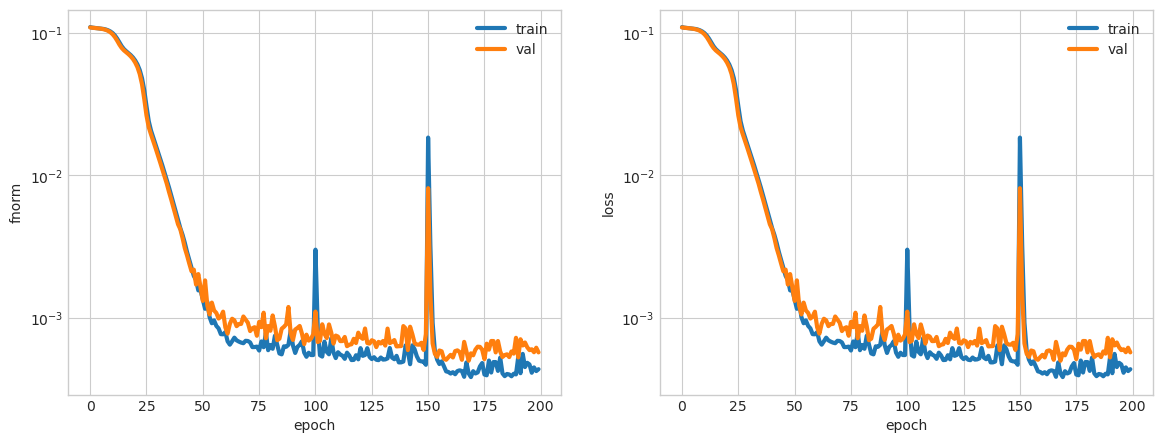

In [118]:
metrics = qp.parse_metrics("%s/%s/csv/metrics.csv"%(save_dir,name))
fig,ax = qp.plot_metrics(metrics,tags=["fnorm","loss"])
metrics.iloc[::max(1,len(metrics)//10)]

### GP

In [22]:
save_dir = ROOT+"/"
name = "NORIS_GP"
resume = True

import gc
gc.collect()
torch.cuda.empty_cache()

gp = qp.IndepVecVGP(
    num_inducing_pts=16,
    num_tasks=(1+(nxticks+2))*(nxticks+2)//2,
    dimension=dataset_chonknoris_train.v.size(-1),
    #mean_module = gpytorch.means.LinearMean(input_size=dataset_chonknoris_train.v.size(-1),batch_shape=torch.Size([(1+(nxticks+2))*(nxticks+2)//2])),
    # covar_module = gpytorch.kernels.ScaleKernel(
    #     gpytorch.kernels.LinearKernel(
    #         batch_shape=torch.Size([(1+(nxticks+2))*(nxticks+2)//2]),
    #         ard_num_dims=dataset_chonknoris_train.v.size(-1)),
    #     batch_shape=torch.Size([(1+(nxticks+2))*(nxticks+2)//2]))
)
gp = gp.double()

noris_gp = qp.LMOpLearnLowerTriMatGP(gp, 
                 automatic_optimization = True, 
                 input_relaxation = False,
                 fixed_noise = True,
                 learning_rate = .1)

assert noris_gp.ftype==dataset_chonknoris_train.v.dtype
print(noris_gp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 150,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    #gradient_clip_val = 1.0,
    #gradient_clip_algorithm = "norm",
  )

trainer.fit(
    model = noris_gp, 
    train_dataloaders = dataloader_chonknoris_train,
    val_dataloaders = dataloader_chonknoris_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./NORIS_GP/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./NORIS_GP/csv/checkpoints exists and is not empty.
Restoring states from the checkpoint path at ././/NORIS_GP/csv/checkpoints/epoch=74-step=3225.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


LMOpLearnLowerTriMatGP(
  (gp): IndepVecVGP(
    (variational_strategy): IndependentMultitaskVariationalStrategy(
      (base_variational_strategy): VariationalStrategy(
        (_variational_distribution): CholeskyVariationalDistribution()
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RQKernel(
        (raw_lengthscale_constraint): Positive()
        (raw_alpha_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (mll): VariationalELBO(
    (likelihood): MultitaskGaussianLikelihood(
      (raw_noise_constraint): GreaterThan(1.000E-08)
    )
    (model): IndepVecVGP(
      (variational_strategy): IndependentMultitaskVariationalStrategy(
        (base_variational_strategy): VariationalStrategy(
          (_variational_distribution): CholeskyVariationalDistribution()
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): RQKernel(
        


  | Name | Type            | Params | Mode 
-------------------------------------------------
0 | gp   | IndepVecVGP     | 1.6 M  | train
1 | mll  | VariationalELBO | 1.6 M  | train
-------------------------------------------------
1.6 M     Trainable params
1         Non-trainable params
1.6 M     Total params
6.537     Total estimated model params size (MB)
13        Modules in train mode
1         Modules in eval mode
Restored all states from the checkpoint at ././/NORIS_GP/csv/checkpoints/epoch=74-step=3225.ckpt


Sanity Checking: |                                                           | 0/? [00:00<?, ?it/s]

/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                  | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


train_fnorm  val_fnorm    train_loss      val_loss
0       0.038607   0.008529  8.553952e+09  3.421116e+08
15      0.000337   0.000411  8.849701e+06  8.232850e+06
30      0.000213   0.000252  3.302970e+06  3.061746e+06
45      0.000150   0.000167  1.841164e+06  1.822019e+06
60      0.000141   0.000142  1.362553e+06  1.325645e+06
75      0.000124   0.000142  1.107883e+06  1.092739e+06
90      0.000124   0.000127  9.402415e+05  9.151733e+05
105     0.000109   0.000129  7.922204e+05  8.051356e+05
120     0.000112   0.000108  7.434959e+05  7.187383e+05
135     0.000098   0.000107  6.332094e+05  6.401843e+05

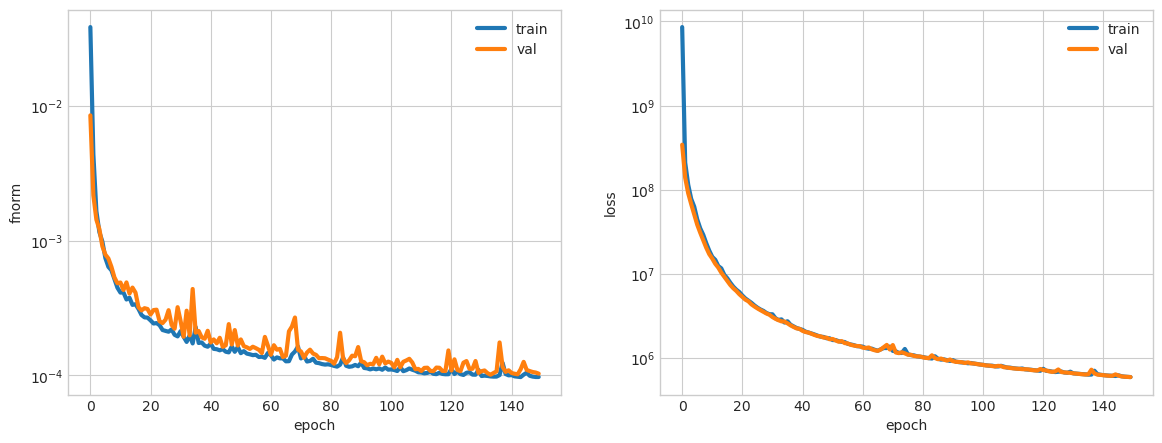

In [23]:
metrics = qp.parse_metrics("%s/%s/csv/metrics.csv"%(save_dir,name))
fig,ax = qp.plot_metrics(metrics,tags=["fnorm","loss"])
metrics.iloc[::max(1,len(metrics)//10)]

## Operator Learning Classic

In [28]:
dataset_classic_train = qp.DatasetClassicOpLearn(uticks_train,vopt_train[:,-1,:],device=DEVICE,fp32=False)
dataset_classic_val = qp.DatasetClassicOpLearn(uticks_val,vopt_val[:,-1,:],device=DEVICE,fp32=False)
dataloader_classic_train = torch.utils.data.DataLoader(dataset_classic_train,batch_size=2**6,collate_fn=tuple,shuffle=True)
dataloader_classic_val = torch.utils.data.DataLoader(dataset_classic_val,batch_size=len(dataset_classic_val),collate_fn=tuple,shuffle=False)
print("len(dataset_classic_train):",len(dataset_classic_train))
print("len(dataset_classic_val):",len(dataset_classic_val))
print("len(dataloader_chonknoris_train):",len(dataloader_classic_train))
print("len(dataloader_chonknoris_val):",len(dataloader_classic_val))

len(dataset_classic_train): 3584
len(dataset_classic_val): 512
len(dataloader_chonknoris_train): 56
len(dataloader_chonknoris_val): 1


### MLP

In [97]:
import gc
gc.collect()
torch.cuda.empty_cache()

save_dir = ROOT+"/"
name = "CLASSIC_MLP"
resume = False

mlp = qp.MultilayerPerceptron(
    mlp_layer_nodes = [dataset_classic_train.u.size(-1),60,70,80,90,100,110,dataset_classic_train.v.size(-1)],
    activation_function = torch.nn.ReLU(),
    batch_norm = False)

mlp = mlp.to(torch.float64)
classic_mlp = qp.ml.lm_oplearn_classic_mlp.LMOpLearnClassicMLP(mlp,automatic_optimization=True,learning_rate=5e-5)

assert classic_mlp.ftype==dataset_classic_train.v.dtype
print(classic_mlp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 500,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    #gradient_clip_val = 1.0,
    #gradient_clip_algorithm = "norm",
  )
trainer.fit(
    model = classic_mlp, 
    train_dataloaders = dataloader_classic_train,
    val_dataloaders = dataloader_classic_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./CLASSIC_MLP/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./CLASSIC_MLP/csv/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type                 | Params | Mode 
----------------------------------------------

LMOpLearnClassicMLP(
  (mlp): MultilayerPerceptron(
    (mlp_sequential): Sequential(
      (0): Linear(in_features=51, out_features=60, bias=True)
      (1): ReLU()
      (2): Linear(in_features=60, out_features=70, bias=True)
      (3): ReLU()
      (4): Linear(in_features=70, out_features=80, bias=True)
      (5): ReLU()
      (6): Linear(in_features=80, out_features=90, bias=True)
      (7): ReLU()
      (8): Linear(in_features=90, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=110, bias=True)
      (11): ReLU()
      (12): Linear(in_features=110, out_features=104, bias=True)
    )
  )
)



Sanity Checking: |                                                           | 0/? [00:00<?, ?it/s]

/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                  | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


train_mse    val_mse
0    10.935106  10.937237
50    2.193279   2.163610
100   0.084679   0.084135
150   0.063626   0.067684
200   0.052151   0.053847
250   0.045649   0.051773
300   0.044027   0.046984
350   0.039157   0.043859
400   0.039958   0.039848
450   0.036902   0.037273

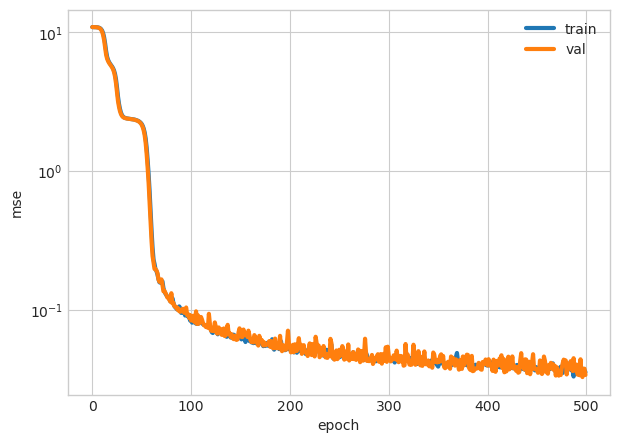

In [98]:
metrics = qp.parse_metrics("%s/%s/csv/metrics.csv"%(save_dir,name))
fig,ax = qp.plot_metrics(metrics)
metrics.iloc[::max(1,len(metrics)//10)]

### GP

In [29]:
save_dir = ROOT+"/"
name = "CLASSIC_GP"
resume = True

import gc
gc.collect()
torch.cuda.empty_cache()

gp = qp.IndepVecVGP(
    num_inducing_pts=8,
    num_tasks=dataset_classic_train.v.size(-1),
    dimension=dataset_classic_train.u.size(-1),
    # mean_module = gpytorch.means.LinearMean(
    #     input_size=dataset_classic_train.u.size(-1),
    #     batch_shape=torch.Size([dataset_classic_train.v.size(-1)])),
    covar_module = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.LinearKernel(
            batch_shape=torch.Size([dataset_classic_train.v.size(-1)]),
            ard_num_dims=dataset_classic_train.u.size(-1)),
        batch_shape=torch.Size([dataset_classic_train.v.size(-1)])))
gp = gp.double()

classic_gp = qp.ml.lm_oplearn_classic_gp.LMOpLearnClassicGP(gp, 
                 automatic_optimization = True, 
                 fixed_noise = True,
                 learning_rate = .1,
                 noise_lb = 1e-8)

assert classic_gp.ftype==dataset_classic_train.v.dtype
print(classic_gp)
print()

csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 125,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    #gradient_clip_val = 1.0,
    #gradient_clip_algorithm = "norm",
  )

trainer.fit(
    model = classic_gp, 
    train_dataloaders = dataloader_classic_train,
    val_dataloaders = dataloader_classic_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./CLASSIC_GP/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./CLASSIC_GP/csv/checkpoints exists and is not empty.
Restoring states from the checkpoint path at ././/CLASSIC_GP/csv/checkpoints/epoch=99-step=1400-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5

LMOpLearnClassicGP(
  (gp): IndepVecVGP(
    (variational_strategy): IndependentMultitaskVariationalStrategy(
      (base_variational_strategy): VariationalStrategy(
        (_variational_distribution): CholeskyVariationalDistribution()
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): LinearKernel(
        (raw_variance_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (mll): VariationalELBO(
    (likelihood): MultitaskGaussianLikelihood(
      (raw_noise_constraint): GreaterThan(1.000E-08)
    )
    (model): IndepVecVGP(
      (variational_strategy): IndependentMultitaskVariationalStrategy(
        (base_variational_strategy): VariationalStrategy(
          (_variational_distribution): CholeskyVariationalDistribution()
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): LinearKernel(
          (raw_variance_constraint): Positive()
  

Sanity Checking: |                                                           | 0/? [00:00<?, ?it/s]

/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.
/home/agsorok/miniconda3/envs/qmcpy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=159` in the `DataLoader` to improve performance.


Training: |                                                                  | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                                | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=125` reached.


train_loss      val_loss  train_mse   val_mse
0    6.899219e+12  4.495362e+11   5.166282  2.439437
12   1.946338e+08  1.774841e+08   0.009788  0.009723
24   4.699999e+07  4.494126e+07   0.009574  0.009586
36   2.140383e+07  2.083550e+07   0.009569  0.009667
48   1.314961e+07  1.293816e+07   0.009604  0.009648
60   9.671249e+06  9.542243e+06   0.009639  0.009596
72   7.975627e+06  7.895927e+06   0.009661  0.009604
84   6.978306e+06  6.935573e+06   0.009574  0.009599
96   6.459517e+06  6.447369e+06   0.009684  0.009691
108  5.992319e+06  5.923473e+06   0.010209  0.010123
120  5.608354e+06  5.682351e+06   0.010231  0.010669

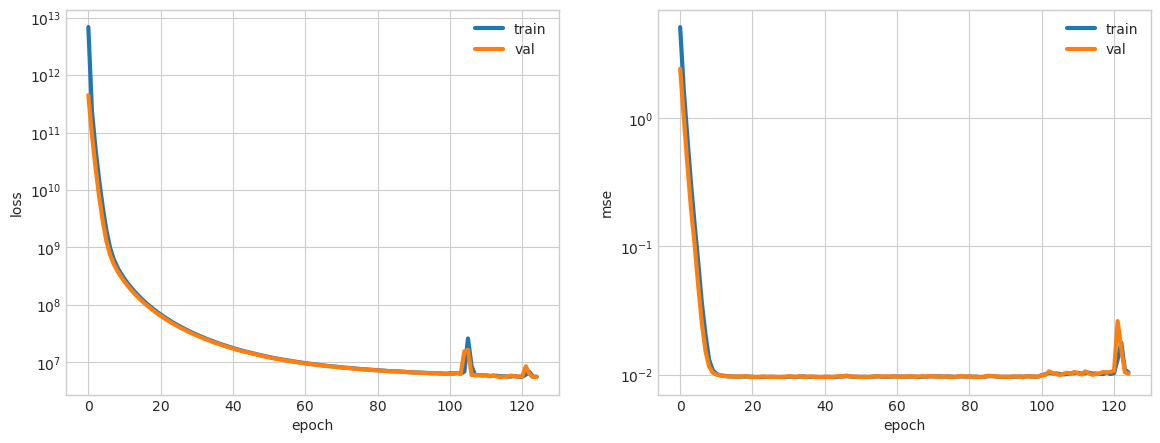

In [30]:
metrics = qp.parse_metrics("%s/%s/csv/metrics.csv"%(save_dir,name))
fig,ax = qp.plot_metrics(metrics)
metrics.iloc[::max(1,len(metrics)//10)]

## Inference

In [31]:
#noris = noris_mlp
noris = noris_gp
#classic = classic_mlp
classic = classic_gp

In [187]:
class NORISPrecond(qp.kernel_methods.pcg_module.preconditioners._BasePrecond):
    def __init__(self, v):
        self.v = v
    def solve(self, y):
        x = noris.linsolve(y,self.v)
        return x
noris.eval()
noris.to("cpu")
#classic.train()
# classic.to(DEVICE)
ridxs = [i for i in range(4)]
numrs = len(ridxs)
maxiter = 5
numpreds = maxiter+1
vhat_ref = [None]*numrs
vhat_enhanced = [None]*numrs
times_ref = [None]*numrs
times_enhanced = [None]*numrs
for i,r in enumerate(ridxs):
    print("ridxs[%d] = %d"%(i,r))
    u_r = uticks_val[r]
    def pde_lhs_r(ly_i, ly_b):
        v_i,v_laplace_i = ly_i
        v_b = ly_b[0]
        lhs_i = C1*v_i**3+C2*v_laplace_i
        lhs_b = v_b
        return lhs_i,lhs_b
    def pde_rhs_r(x_i, x_b):
        y_i = u_r
        y_b = torch.zeros(len(x_b),dtype=float)
        return y_i,y_b
    with torch.no_grad():
        t0 = time.perf_counter()
        u_r_g = u_r.to(DEVICE)[None,:]
        z0_g = classic.forward(u_r_g)[0]
        z0 = z0_g.cpu()
        t_init = time.perf_counter()-t0
    print("  Reference Method")
    y_ref,data_ref = ki.pde_opt_gauss_newton(
        pde_lhs = pde_lhs_r,
        pde_rhs = pde_rhs_r,
        maxiter = maxiter,
        #precond_setter = lambda pde_gm: qp.kernel_methods.IdentityPrecond(),
        #z0 = z0,
        verbose = 1)
    vhat_ref[i] = data_ref["zhist"][:,:nxticks]
    times_ref[i] = data_ref["times"]
    print("  Enhanced Method")
    y_enhanced,data_enhanced = ki.pde_opt_gauss_newton(
        pde_lhs = pde_lhs_r,
        pde_rhs = pde_rhs_r,
        maxiter = maxiter,
        custom_lin_solver = lambda v,y: noris.linsolve(y,v),
        #precond_setter = lambda pde_gm: NORISPrecond(pde_gm.z),
        #z0 = z0,
        verbose = 1)
    vhat_enhanced[i] = data_enhanced["zhist"][:,:nxticks]
    times_enhanced[i] = data_enhanced["times"]#+t_init
    print()
vhat_ref = torch.stack(vhat_ref)
times_ref = torch.stack(times_ref)
l2rerrs_ref = torch.linalg.norm(vhat_ref-vticks_val[ridxs,None,:],dim=2)/torch.linalg.norm(vticks_val[ridxs,None,:],dim=2)
aerrs_ref = torch.abs(vhat_ref[:,-1,:]-vticks_val[ridxs,:])

vhat_enhanced = torch.stack(vhat_enhanced)
times_enhanced = torch.stack(times_enhanced)
l2rerrs_enhanced = torch.linalg.norm(vhat_enhanced-vticks_val[ridxs,None,:],dim=2)/torch.linalg.norm(vticks_val[ridxs,None,:],dim=2)
aerrs_enhanced = torch.abs(vhat_enhanced[:,-1,:]-vticks_val[ridxs,:])

with np.printoptions(formatter={"float":lambda x: "%.1e"%x}):
    print("l2rerrs_enhanced")
    print(l2rerrs_enhanced.numpy())
    print()

ridxs[0] = 0
  Reference Method
    iter (5 max)   loss           time           
    0              1.00e+01       3.94e-04       
    1              4.11e-02       2.98e-03       
    2              1.44e-05       4.15e-03       
    3              2.17e-12       5.29e-03       
    4              1.05e-12       6.28e-03       
    5              1.19e-12       7.37e-03       
  Enhanced Method
    iter (5 max)   loss           time           
    0              1.00e+01       2.04e-04       
    1              2.39e+01       7.45e-02       
    2              2.47e+02       2.00e-01       
    3              6.32e+02       2.08e-01       
    4              2.51e+03       2.16e-01       
    5              4.50e+08       2.23e-01       

ridxs[1] = 1
  Reference Method
    iter (5 max)   loss           time           
    0              1.86e+01       2.90e-04       
    1              7.55e-02       1.75e-03       
    2              4.90e-05       3.05e-03       
    3            

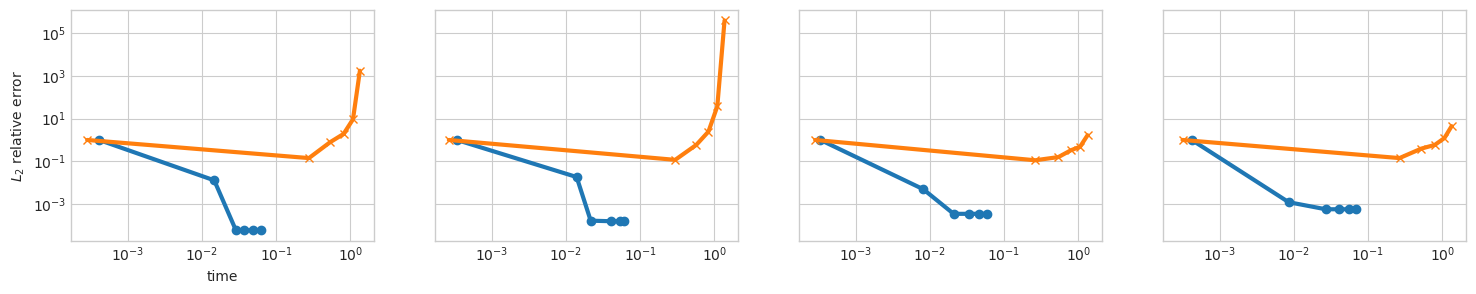

In [182]:
fig,ax = pyplot.subplots(nrows=1,ncols=numrs,figsize=(6*3,3),sharey=True,sharex=True)
ax = np.atleast_1d(ax)
for i,r in enumerate(ridxs):
    ax[i].plot(times_ref[i,:],l2rerrs_ref[i,:],marker='o',linewidth=LW)#,color=COLORS[i])
    ax[i].plot(times_enhanced[i,:],l2rerrs_enhanced[i,:],marker='x',linewidth=LW) #,linestyle='dashed',color=COLORS[i]
ax[0].set_yscale("log",base=10)
ax[0].set_xscale("log",base=10)
ax[0].set_xlabel("time")
ax[0].set_ylabel(r"$L_2$ relative error");
# ax[1].set_yscale("log",base=10)
# ax[1].set_xscale("log",base=10)

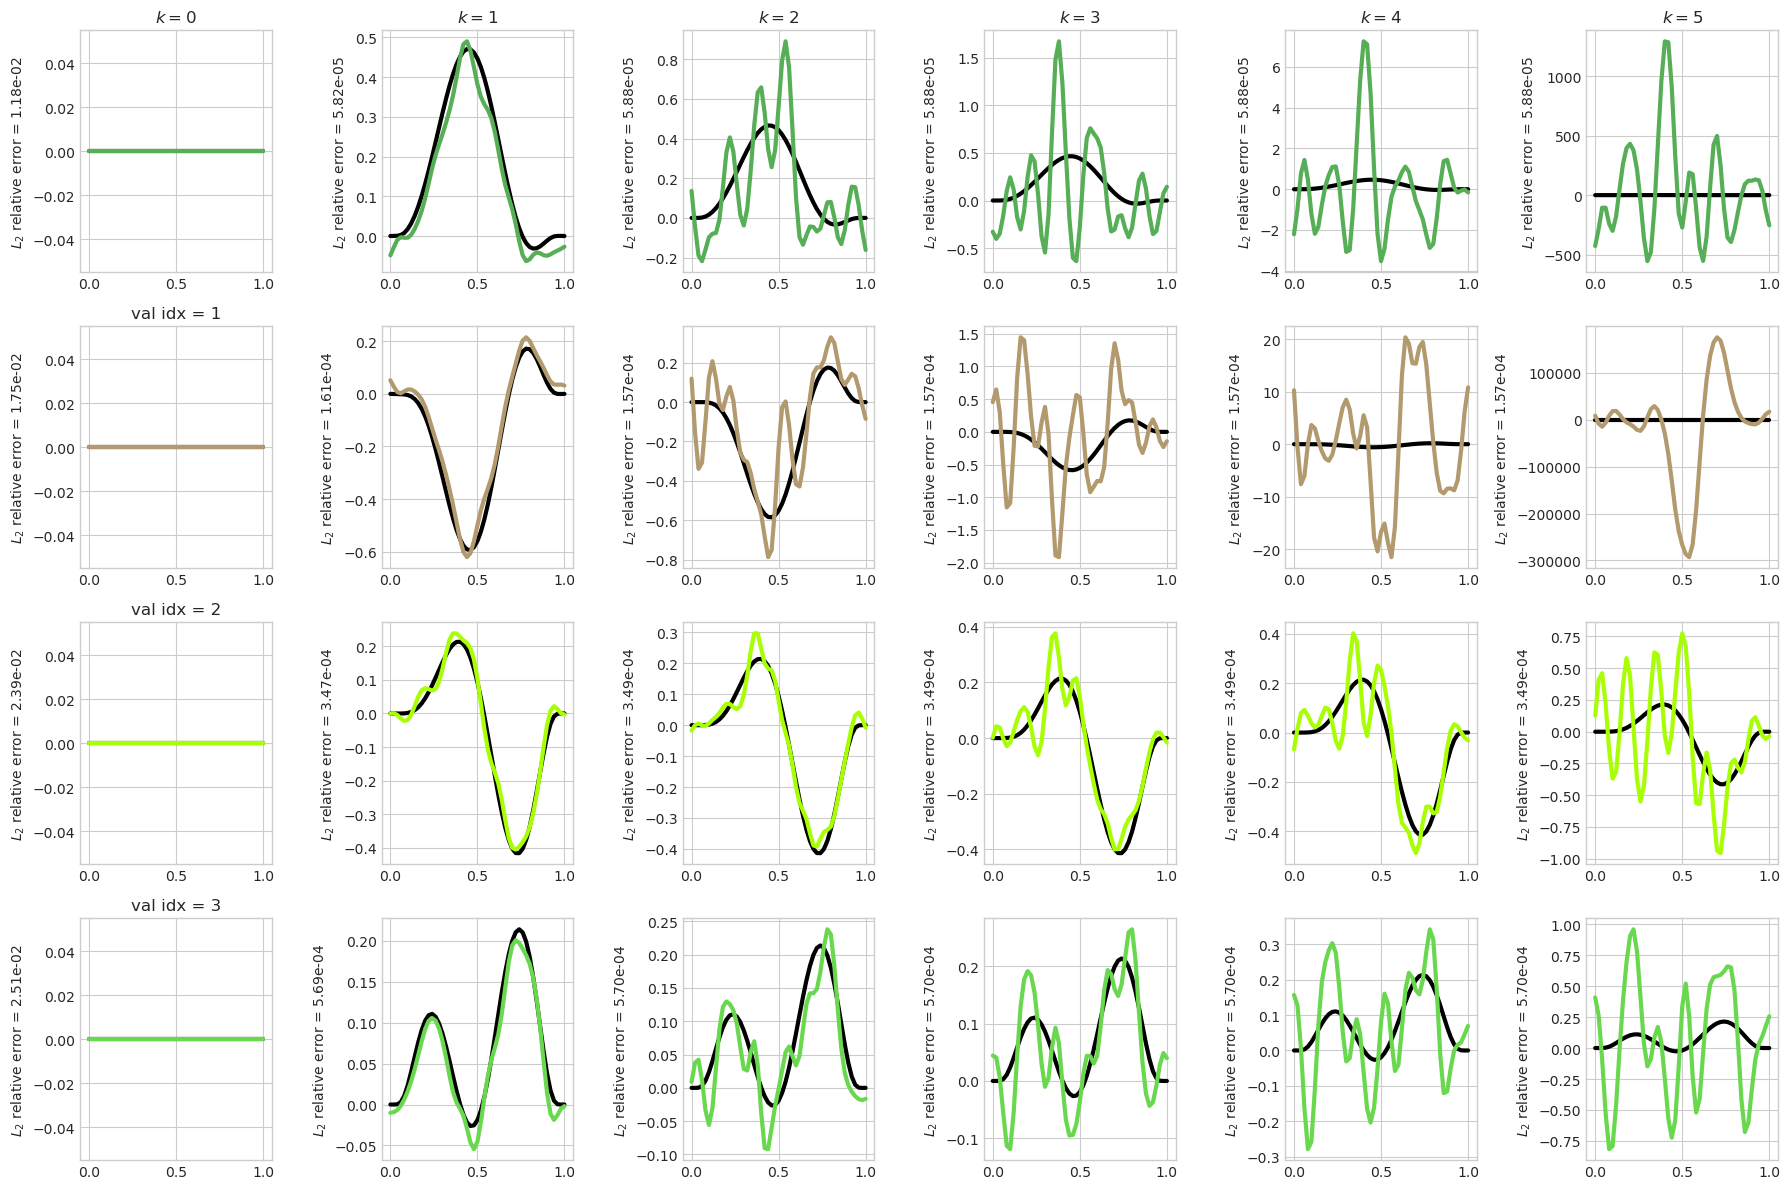

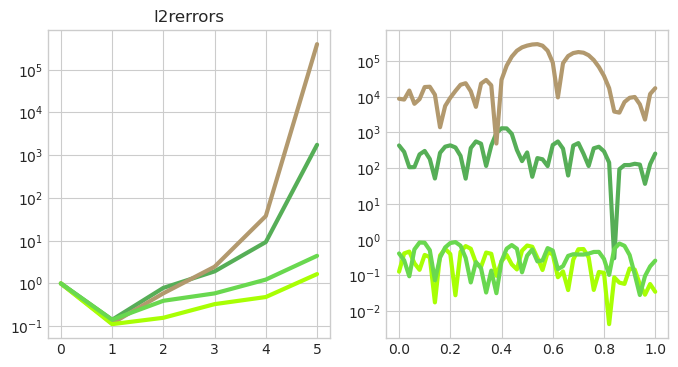

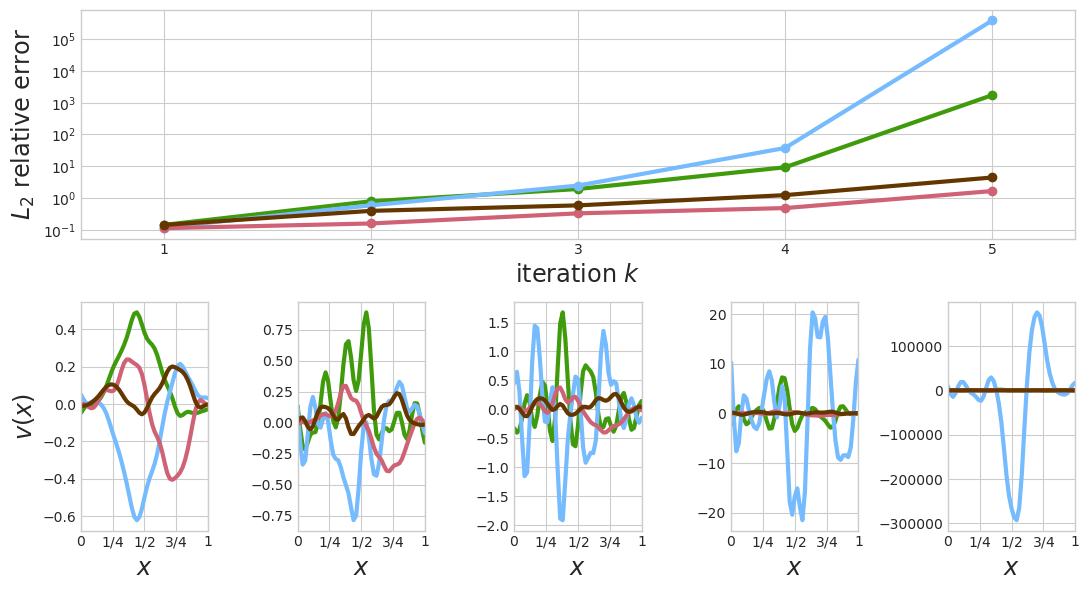

In [189]:
fig,ax = pyplot.subplots(nrows=numrs,ncols=numpreds,figsize=(3*numpreds,3*numrs))
for i in range(numrs):
    #ymin,ymax = vhat[i,:,:nxticks].min(),vhat[i,:,:nxticks].max()
    ymin,ymax = vhat_enhanced.min(),vhat_enhanced.max()
    yymin,yymax = ymin-(ymax-ymin)*.1,ymax+(ymax-ymin)*.1
    for k in range(numpreds):
        if k<vopt.size(1):
            ax[i,k].plot(xticks,vopt_val[ridxs[i],k,:nxticks],linewidth=LW,color="k")
        ax[i,k].plot(xticks,vhat_enhanced[i,k,:nxticks],linewidth=LW,color=COLORS[i])
        #ax[i,k].set_ylim([yymin,yymax])
        #if k>0:
        ax[i,k].set_ylabel(r"$L_2$ relative error = %.2e"%l2rerrors[i,k])
for i in range(numrs):
    ax[i,0].set_title("val idx = %d"%ridxs[i])
for k in range(numpreds):
    ax[0,k].set_title(r"$k = %d$"%k)
fig.tight_layout()
fig.show()
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=((8,4)))
for i in range(numrs):
    ax[0].plot(torch.arange(numpreds),l2rerrs_enhanced[i],linewidth=LW,color=COLORS[i])
    ax[1].plot(xticks,aerrs_enhanced[i],linewidth=LW,color=COLORS[i])
ax[0].set_title("l2rerrors")
for i in range(2):
    ax[i].set_yscale("log",base=10)
fig.show()
fig = pyplot.figure(figsize=(11,6))
_gs = gridspec.GridSpec(2,numpreds-1) 
CUSTOMCOLORS = ["xkcd:grass green","xkcd:sky blue","xkcd:rose","xkcd:brown"]+COLORS
ax = fig.add_subplot(_gs[0,:])
for i in range(numrs):
    ax.plot(torch.arange(1,numpreds),l2rerrs_enhanced[i,1:],marker="o",linewidth=LW,color=CUSTOMCOLORS[i])
ax.set_yscale("log",base=10)
ax.set_xlim([.6,numpreds-.6])
ax.set_xlabel(r"iteration $k$",fontsize="xx-large")
ax.set_ylabel(r"$L_2$ relative error",fontsize="xx-large")
ax = np.empty(numpreds-1,dtype=object)
for k in range(numpreds-1):
    ax[k] = fig.add_subplot(_gs[1,k])
    ax[k].set_xlim([0,1])
    ax[k].set_xticks([0,1/4,1/2,3/4,1])
    ax[k].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
    #ax[k].set_ylim([ymin-.05*(ymax-ymin),ymax+.05*(ymax-ymin)])
    ax[k].set_xlabel(r"$x$",fontsize="xx-large")
ymin,ymax = vhat_enhanced[:,1:numpreds,:nxticks].min(),vhat_enhanced[:,1:numpreds,:nxticks].max()
for k in range(numpreds-1):
    for i in range(numrs):
        ax[k].plot(xticks,vhat_enhanced[i,k+1,:nxticks],linewidth=LW,color=CUSTOMCOLORS[i])
for k in range(1,numpreds-1):
    pass#ax[k].set_yticklabels([""]*len(ax[k].get_yticklabels()))#get_yaxis().set_visible(False)
ax[0].set_ylabel(r"$v(x)$",fontsize="xx-large")
fig.tight_layout()
#fig.savefig("./superres.png",dpi=512,bbox_inches="tight")